# 1. Spectral Clustering

In [11]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
import scipy.sparse as sps
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1.2.1 Implement this algorithm using different graph Laplacians

In [7]:
def construct_laplacian(A, norm_type=None):
    """Construct Laplacian of a graph.
    
    Parameters
    ----------
    A : scipy.sparse.csr_matrix, shape [N, N]
        Adjacency matrix of the graph.
    norm_laplacian : bool
        Whether to construct the normalized graph Laplacian or not.
        If True, construct the normalized (symmetrized) Laplacian, L = I - D^{-1/2} A D^{-1/2}.
        If False, construct the unnormalized Laplacian, L = D - A.
        
    Returns
    -------
    L : scipy.sparse.csr_matrix, shape [N, N]
        Laplacian of the graph.
        
    """
    if sps.issparse(A):
        A = A.toarray()
    D = A.sum(axis=0)
    if norm_type is None:
        L = np.diag(D) - A
    elif norm_type == 'random_walk':
        factor = np.diag(1. / D)
        L = np.eye(len(D)) - factor.dot(A)
    elif norm_type == 'symmetric':
        factor = np.diag(1. / np.sqrt(D))
        L = np.eye(len(D)) - factor.dot(A).dot(factor)
    else:
        raise TypeError('Unknown norm_type: "{}"'.format(norm_type))
    return L

In [8]:
def spectral_embedding(A, num_lambda=1, norm_type=None):
    """Compute spectral embedding of nodes in the given graph.
    
    Parameters
    ----------
    A : scipy.sparse.csr_matrix, shape [N, N]
        Adjacency matrix of the graph.
    num_clusters : int
        Number of clusters to detect in the data.
    norm_laplacian : bool, default False
        Whether to use the normalized graph Laplacian or not.
        
    Returns
    -------
    embedding : np.array, shape [N, num_clusters]
        Spectral embedding for the given graph.
        Each row represents the spectral embedding of a given node.
    
    """
    L = construct_laplacian(A, norm_type).astype(np.float64)
    eigvals, eigvectors = eigsh(L, k=1+num_lambda, which='SM')
    return eigvectors[:, 1:num_lambda+1]

In [9]:
def spectral_clustering(A, num_clusters, num_lambda=1, norm_type=None):
    """Perform spectral clustering on the given graph.
    
    Parameters
    ----------
    A : scipy.sparse.csr_matrix, shape [N, N]
        Adjacency matrix of the graph.
    num_clusters : int
        Number of clusters to detect in the data.
    norm_laplacian : bool, default False
        Whether to use the normalized graph Laplacian or not.
        
    Returns
    -------
    z_pred : np.array, shape [N]
        Predicted cluster indicators for each node.
        
    """
    eigvectors = spectral_embedding(A, num_lambda, norm_type)
    cst = KMeans(num_clusters)
    cst.fit(eigvectors)
    return cst.predict(eigvectors)

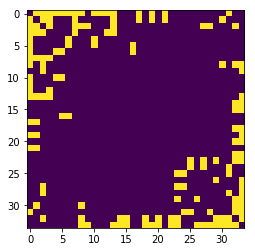

In [444]:
A = np.load('./karate_club.npy')
plt.imshow(A)

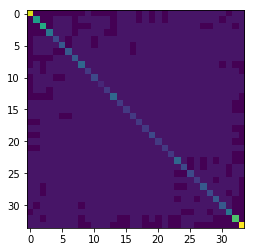

In [8]:
L = construct_laplacian(A)
plt.imshow(L)

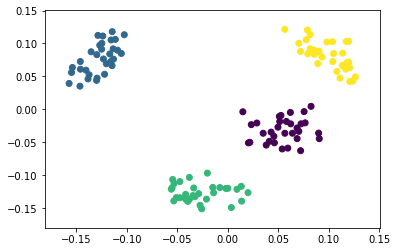

In [9]:
network = np.load('network.npy')
features = spectral_embedding(network, num_lambda=2)
labels = spectral_clustering(network, num_clusters=4, num_lambda=2)
plt.scatter(features[:, 0], features[:, 1], c=labels)

### 1.2.2 Theoretical questions

a) From network point of view, what does Symmetric normalization do?

На диагонали $D$ стоят степени вершин. Соответственно, превращение матрицы $A$ в матрицу $D^{-1/2}AD^{-1/2}$ имеет смысл перераспределения весов на рёбрах графа, так чтобы сумма весов рёбер, входящих в каждую вершину (аналог степени вершины), была одинаковой.

b) Under what conditions Symmetric and Random walk normalizations yield the same result?
\begin{align}
D^{-1}A &= D^{-1/2}AD^{-1/2} \\
D^{-1/2}A &= AD^{-1/2}
\end{align}

Т.к. граф неориентированный, матрица $A$ симметрична. Обозначим её столбцы $a_i$, а элементы на диагонали $D^{-1/2}$ - $d_i$:
\begin{align}
A &= (a_1 ... a_n) = \begin{pmatrix} a_1^T \\ \vdots \\ a_n^T \end{pmatrix} \\
d &= diag(d_1, ..., d_n) \\
D^{-1/2}A &= \begin{pmatrix} d_1a_1^T \\ \vdots \\ d_na_n^T \end{pmatrix} \\
AD^{-1/2} &= (d_1a_1 ... d_na_n)
\end{align}

Равенство $D^{-1/2}A = AD^{-1/2}$ возможно только в случае, когда граф разбивается на компоненты связности, в каждой из которых степени вершин одинаковы (т.е. каждая компонента является $k$-регулярным графом). При этом для разных компонент $k$ могут быть разными.

### 1.2.3 Compare results of 1(a), 1(b) and 1(c) on Karate club network and artificial network (network.npy)

In [10]:
from sklearn.metrics import adjusted_rand_score

In [11]:
network = np.load('./network.npy')
karate = np.load('./karate_club.npy')

In [12]:
def reorder_after_clusterization(A, labels):
    shuffle = np.argsort(labels)
    return A[shuffle, :][:, shuffle]

def plot_results_clusterization(A, num_clusters, num_lambda=1):
    to_plot = [A.copy()]
    titles = ['До кластеризации', 'Ненормированный лапласиан', 'Симметричная нормализация', 'Random walk']
    for norm_type in [None, 'symmetric', 'random_walk']:
        labels = spectral_clustering(A, num_clusters, num_lambda, norm_type)
        to_plot.append(reorder_after_clusterization(A, labels))
    plt.figure(figsize=(20, 10))
    plt.suptitle('Количество кластеров: {}, количество фичей: {}'.format(num_clusters, num_lambda), fontsize=15)
    for i, mat, title in zip(range(1, 5), to_plot, titles):
        plt.subplot(1, 4, i)
        plt.imshow(mat)
        plt.title(title + 'ARS = {}')

def plot_results_clusterization_scatter(A, num_clusters):
    to_plot = []
    titles = ['Ненормированный лапласиан', 'Симметричная нормализация', 'Random walk']
    for norm_type in [None, 'symmetric', 'random_walk']:
        eigvectors = spectral_embedding(A, num_lambda=2, norm_type=norm_type)
        labels = spectral_clustering(A, num_clusters, num_lambda=2, norm_type=norm_type)
        to_plot.append(eigvectors)
    plt.figure(figsize=(21, 7))
    plt.suptitle('Количество кластеров: {}'.format(num_clusters), fontsize=15)
    for i, data, title in zip(range(1, 4), to_plot, titles):
        plt.subplot(1, 3, i)
        plt.scatter(data[:, 0], data[:, 1], c=labels)
        plt.title(title)

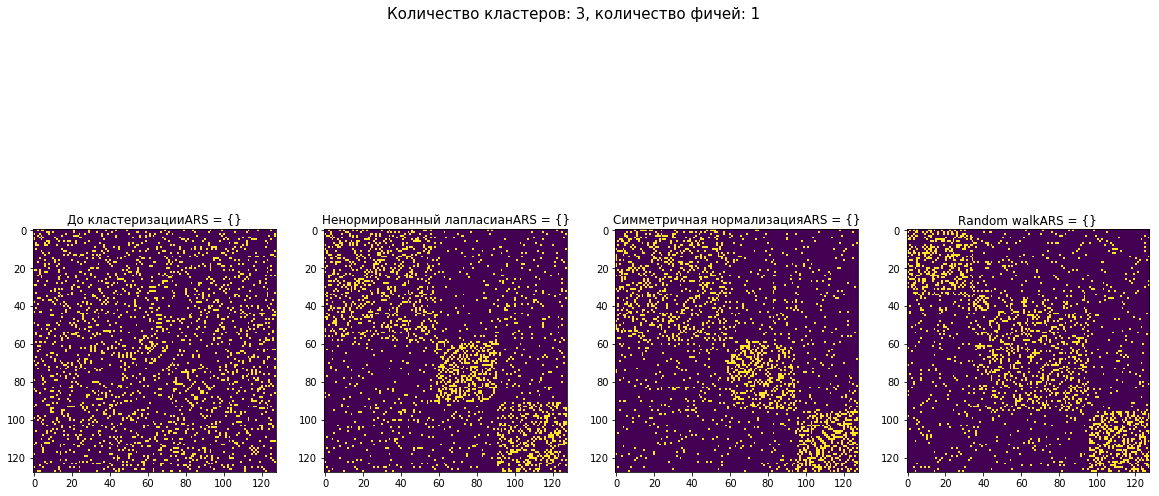

In [13]:
plot_results_clusterization(network, 3, 1)

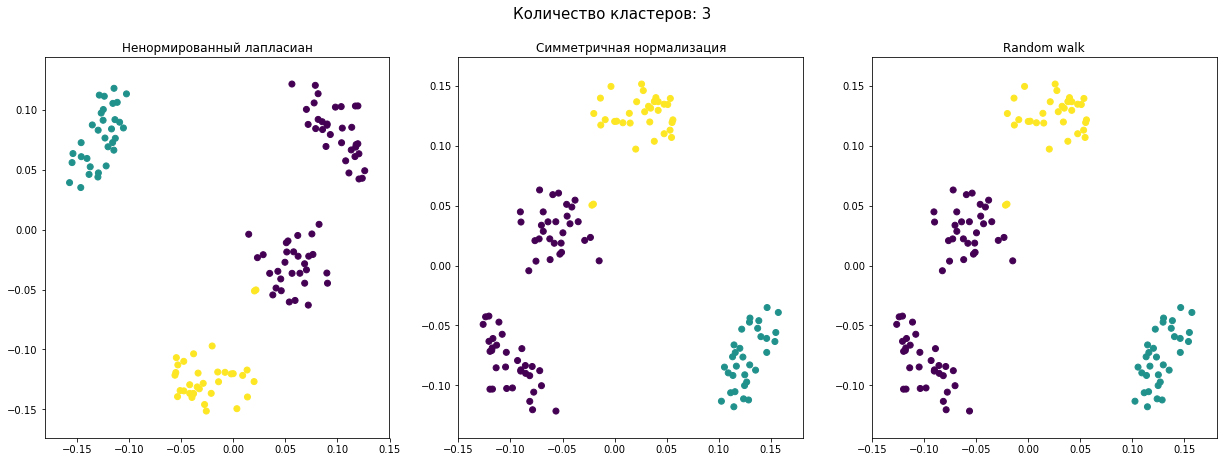

In [14]:
plot_results_clusterization_scatter(network, 3)

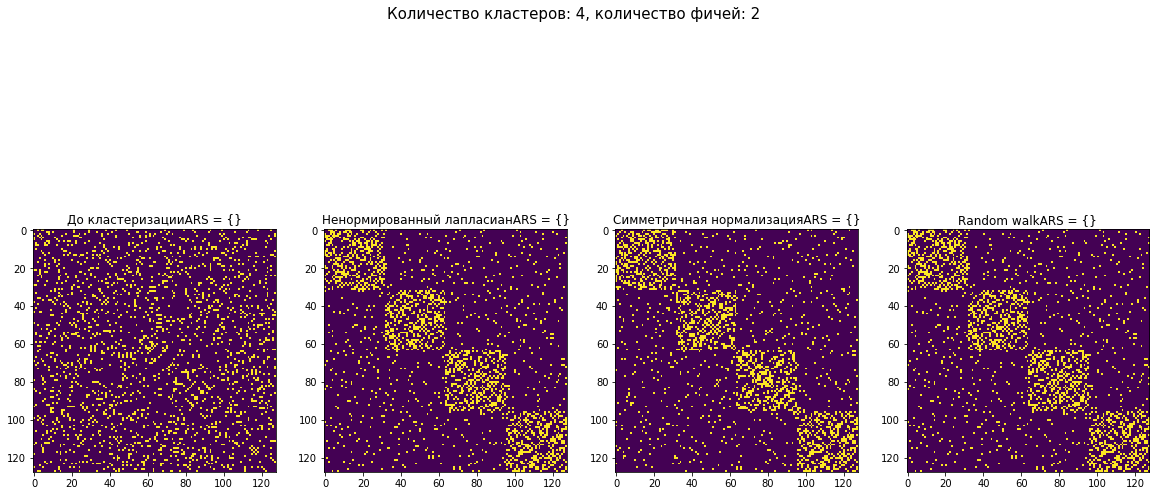

In [15]:
plot_results_clusterization(network, 4, 2)

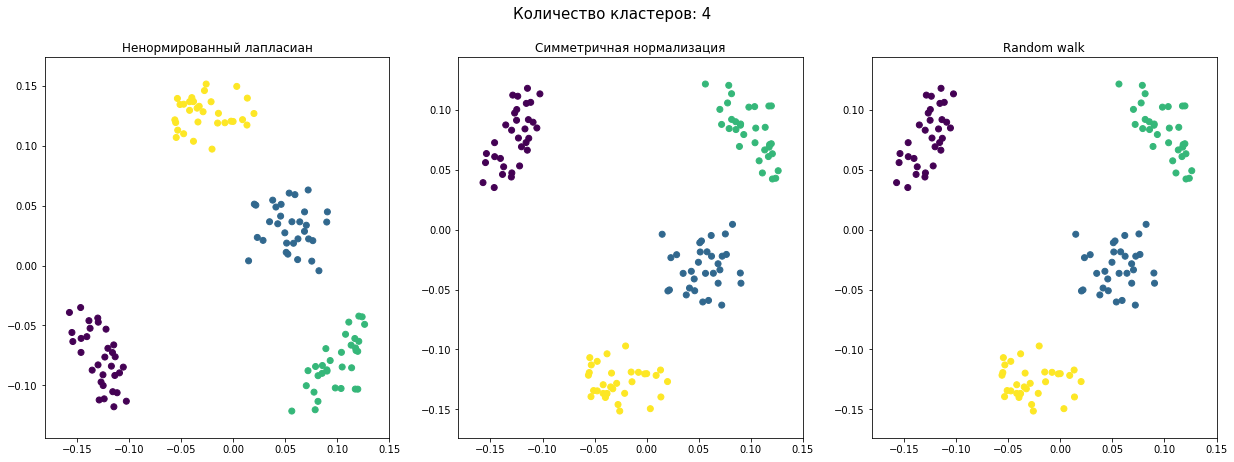

In [16]:
plot_results_clusterization_scatter(network, 4)

Осталось посмотреть Adjusted rand score. Но истинные метки нам неизвестны. На самом деле, из картинки выше видно, что кластеризуется "так, как надо". Чтобы убедиться, убедимся, что ARS между всеми способами кластеризации равен 1.0. 

In [17]:
labels = [
    spectral_clustering(network, 2, 2, None), 
    spectral_clustering(network, 2, 2, 'symmetric'), 
    spectral_clustering(network, 2, 2, 'random_walk')
]

In [18]:
from itertools import combinations
for first, second in combinations(labels, 2):
    print(adjusted_rand_score(first, second))

1.0
1.0
1.0


#### Проделаем то же самое с karate.npy

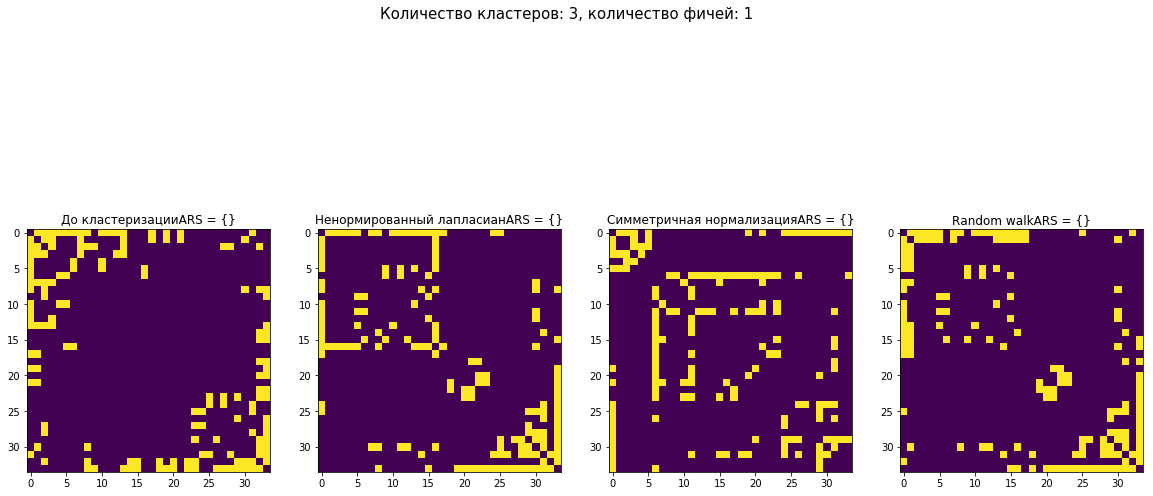

In [19]:
plot_results_clusterization(karate, 3, 1)

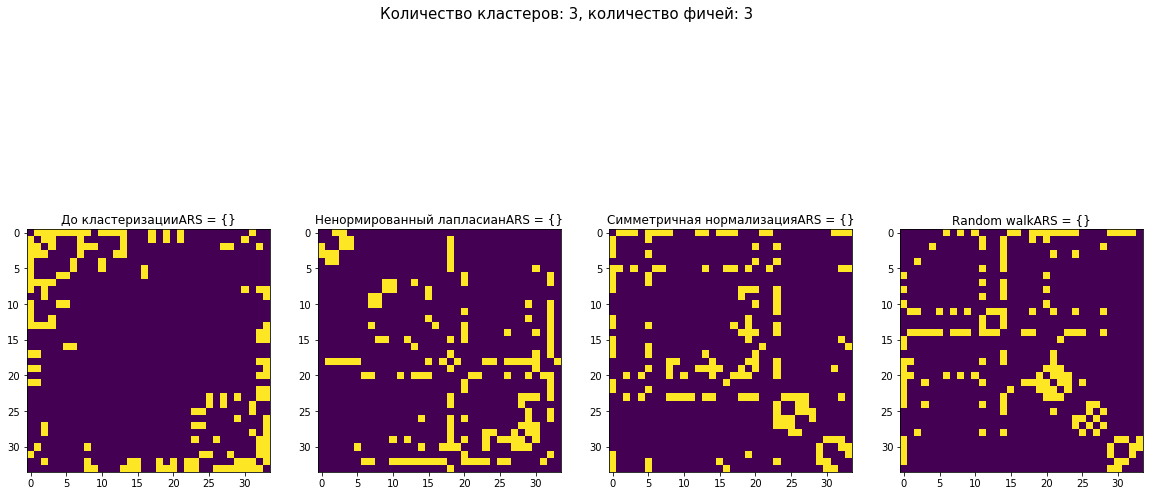

In [20]:
plot_results_clusterization(karate, 3, 3)

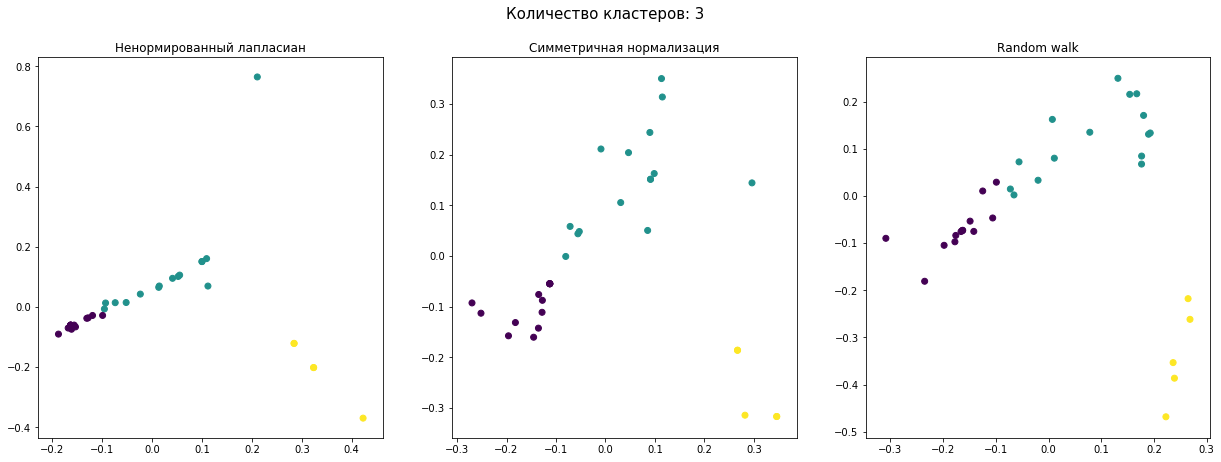

In [21]:
plot_results_clusterization_scatter(karate, 3)

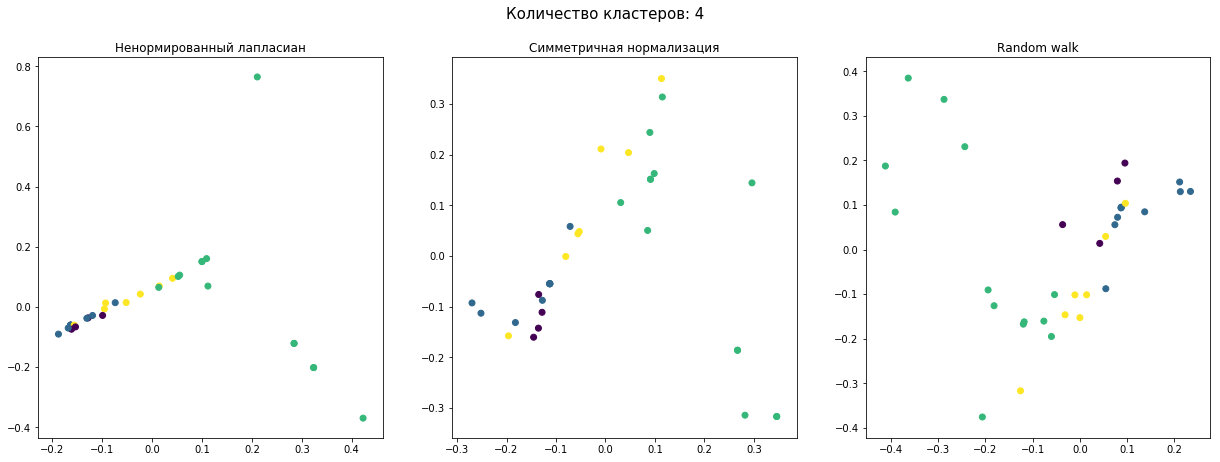

In [22]:
plot_results_clusterization_scatter(karate, 4)

К сожалению, ничего вразумительного. 

# 2. Label Propagation

In [23]:
import networkx as nx

In [29]:
def label_propagation(adj_mat, strategy='random_from_max', return_history=False, random_state=None):
    np.random.seed(random_state)
    adj_mask = adj_mat.astype(np.bool)
    labels = np.asarray(range(adj_mat.shape[0]))
    old_labels = np.zeros(adj_mat.shape[0], dtype=np.int)
    hist = []
    while np.any(labels != old_labels):
        old_labels = labels.copy()
        order = np.asarray(range(adj_mat.shape[0]))
        np.random.shuffle(order)
        for ind in order:
            colors_for_ind = labels[adj_mask[ind]]
            unique_colors, counts = np.unique(colors_for_ind, return_counts=True)
            if strategy == 'random_from_max':
                colors_with_max_weight = unique_colors[counts == counts.max()]
                chosen_color = np.random.choice(colors_with_max_weight)
            elif strategy == 'first_from_max':
                colors_with_max_weight = unique_colors[counts == counts.max()]
                chosen_color = colors_with_max_weight[0]
            elif strategy == 'random_proportional':
                chosen_color = np.random.choice(unique_colors, p=counts/counts.sum())
            else:
                raise TypeError('Unknown strategy "{}"'.format(strategy))
            labels[ind] = chosen_color
        if return_history:
            hist.append(old_labels)
    
    if return_history:
        return labels, hist
    else:
        return labels

4 clusters


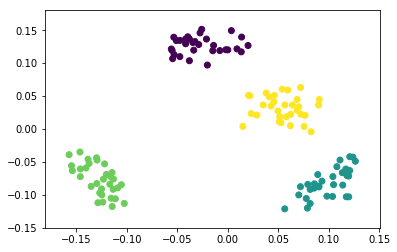

In [30]:
labels = label_propagation(network, 'random_from_max', random_state=6)
eigvectors = spectral_embedding(network, 2)
plt.scatter(eigvectors[:, 0], eigvectors[:, 1], c=labels)
print('{} clusters'.format(len(np.unique(labels))))

Если у вершины есть несколько цветов, каждому из которых соответствует максимальное число соседей, то цвет самой вершины можно определить по-разному.

* Выбрать первый из наиболее часто встречающихся цветов (first_from_max)
* Выбрать случайный цвет из наиболее часто встречающихся (random_from_max)
* Выбрать цвет с вероятностью, пропорциональной его количеству в соседях (random_proportional) 

In [34]:
def plot_results_label_propagation(mat):
    to_plot = []
    titles = ['Спектральная кластеризация', 'Случайный цвет из самых частых', 
              'Первый цвет из самых частых', 'Вероятности, пропорциональные частоте']
    labels_spectral = spectral_clustering(mat, num_clusters=4, num_lambda=2, norm_type='symmetric')
    eigvectors = spectral_embedding(mat, num_lambda=2, norm_type='symmetric')
#     to_plot.append(reorder_after_clusterization(mat, labels_spectral))
    to_plot.append(labels_spectral)
    for strategy in ['random_from_max', 'first_from_max', 'random_proportional']:
        labels = label_propagation(mat, strategy)
#         to_plot.append(reorder_after_clusterization(mat, labels))
        to_plot.append(labels)
    plt.figure(figsize=(20, 10))
    for i, labels, title in zip(range(1, 5), to_plot, titles):
        plt.subplot(1, 4, i)
        plt.title(title + '\nНайдено кластеров: {}\nARS = {}'.format(
            len(np.unique(labels)), 
            adjusted_rand_score(labels, labels_spectral)))
        img = reorder_after_clusterization(mat, labels)
        plt.imshow(img)
    
    plt.figure(figsize=(20, 5))
    for i, labels in zip(range(1, 5), to_plot):
        plt.subplot(1, 4, i)
        plt.scatter(eigvectors[:, 0], eigvectors[:, 1], c=labels)

#### Проведём эксперименты. Несколько раз запустим label propagation всеми тремя способами и сравним со спектральной кластеризацией.

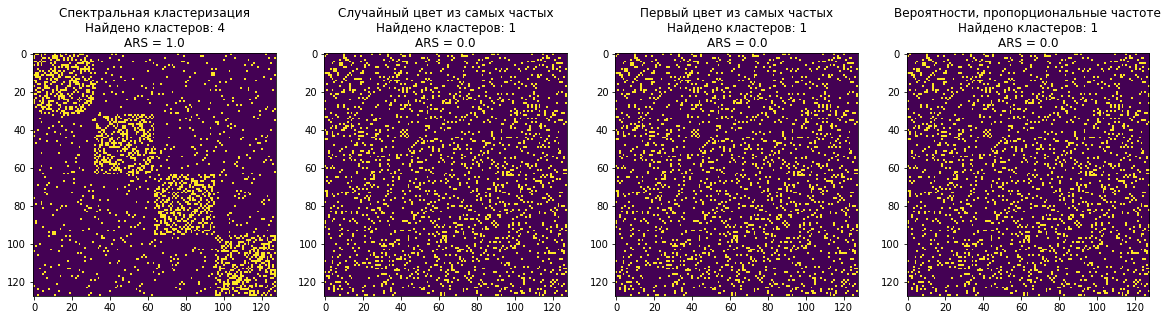

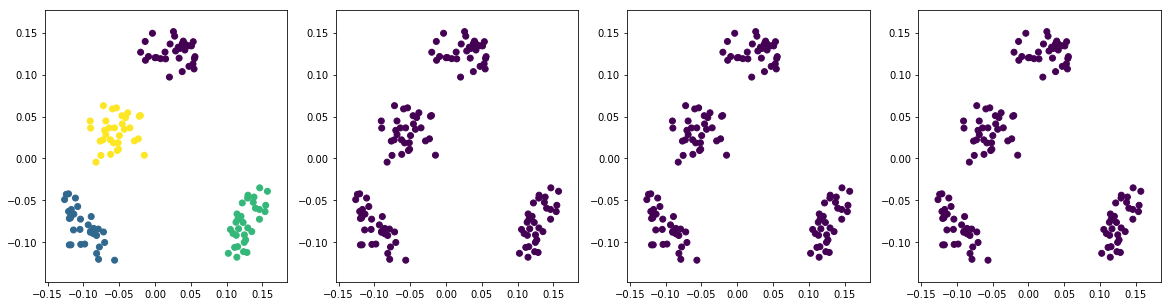

In [37]:
plot_results_label_propagation(network)

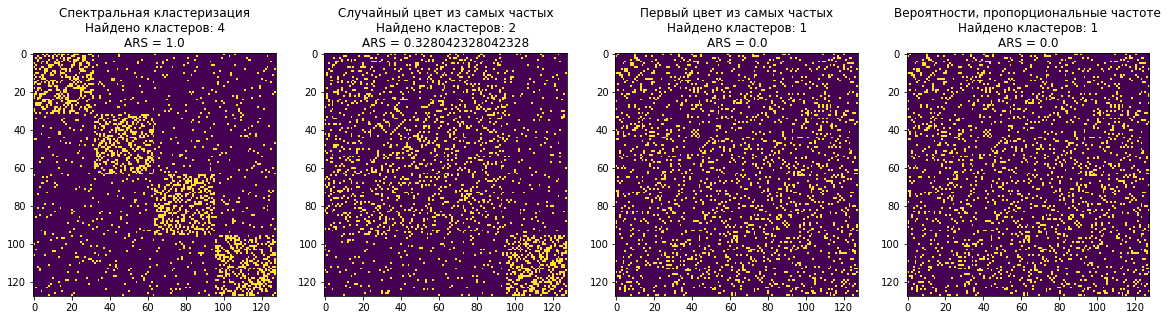

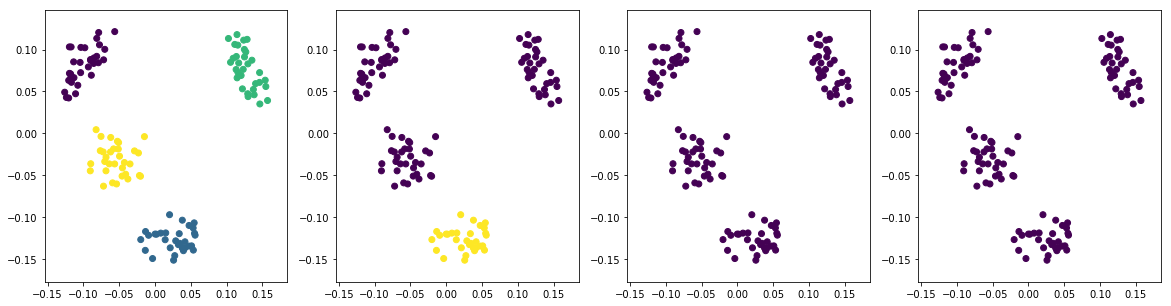

In [42]:
plot_results_label_propagation(network)

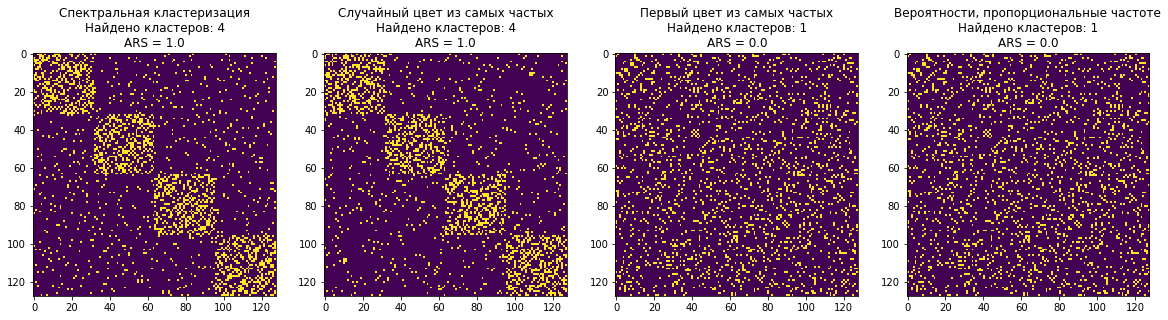

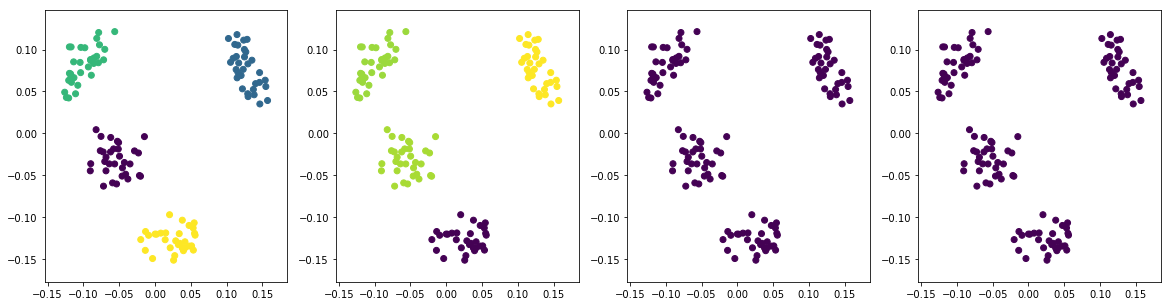

In [39]:
plot_results_label_propagation(network)

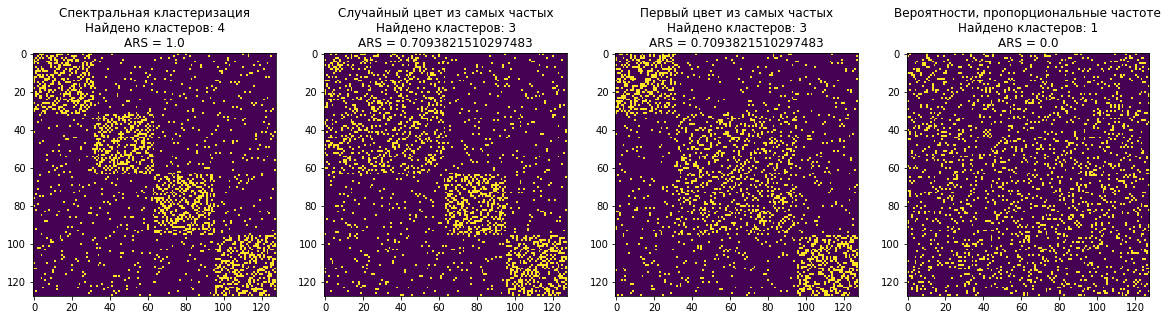

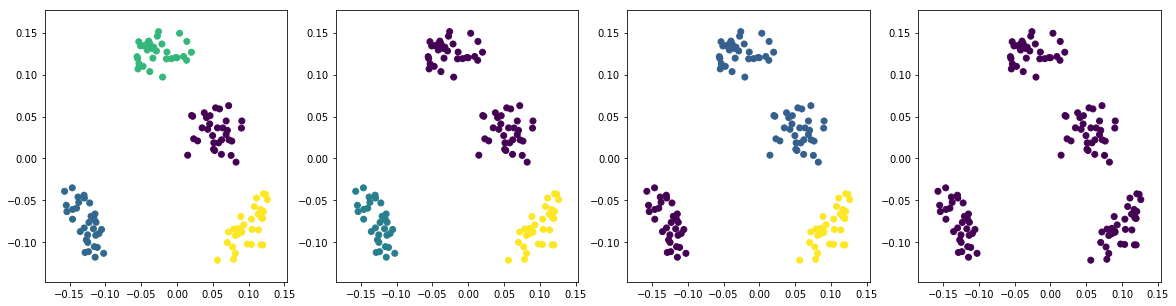

In [43]:
plot_results_label_propagation(network)

#### Выводы:

Label propagation действительно не является робастным алгоритмом (и имеет что-то общее с DBScan). От запуска к запуску получается разное количество кластеров. Однако, проведённые эксперименты показывают, что наилучшая стратегия для работы с неточностью - это выбор случайного цвета из самых частых.

# 3. Unsupervised image segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import itertools
from skimage import io
from skimage.transform import rescale
from skimage.color import rgb2gray
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Перепишем label propagation, чтобы работало со взвешенными графами.

In [2]:
def label_propagation(adj_mat, strategy='random_from_max', return_history=False, max_iterates=1000, random_state=None):
    np.random.seed(random_state)
    labels = np.asarray(range(adj_mat.shape[0]))
    old_labels = np.zeros(adj_mat.shape[0], dtype=np.int)
    hist = []
    step_count = -1
    while np.any(labels != old_labels) and step_count < max_iterates:
        step_count += 1
        old_labels = labels.copy()
        order = np.asarray(range(adj_mat.shape[0]))
        np.random.shuffle(order)
        for ind in order:
            _, inds_nonzero_weights, color_weights = sps.find(adj_mat[ind])
            colors_for_ind = labels[inds_nonzero_weights]
            unique_colors = np.unique(colors_for_ind)
            unique_color_weights = np.zeros_like(unique_colors)
            for i, color in enumerate(unique_colors):
                unique_color_weights[i] = color_weights[colors_for_ind == color].sum()

            if strategy == 'random_from_max':
                colors_with_max_weight = unique_colors[unique_color_weights == unique_color_weights.max()]
                chosen_color = np.random.choice(colors_with_max_weight)
            elif strategy == 'first_from_max':
                colors_with_max_weight = unique_colors[unique_color_weights == unique_color_weights.max()]
                chosen_color = colors_with_max_weight[0]
            elif strategy == 'random_proportional':
                chosen_color = np.random.choice(unique_colors, p=unique_color_weights/unique_color_weights.sum())
            else:
                raise TypeError('Unknown strategy "{}"'.format(strategy))
            labels[ind] = chosen_color
        if return_history:
            hist.append(old_labels)
    
    if return_history:
        return labels, hist
    else:
        return labels

#### Способы уменьшения количества рёбер:

* Отсекать рёбра с малыми весами

* Проводить соединять рёбрами только те вершины, которым соответствуют пиксели, находящиеся недалеко друг от друга

In [94]:
def build_weight_matrix(img, graph_type='full', weight_choice='inverse', img_dist_coef=0.1, 
                        eps=1e-6, radius=None, threshold=None):
    m, n = img.shape[0:2]
    if len(img.shape) == 2:
        img = img.reshape(m, n, 1)
    if graph_type == 'full':
        weights = np.zeros((m*n, m*n))
        for layer_ind in range(img.shape[2]):
            layer = img[:, :, layer_ind].flatten()
            layer_repeated = np.tile(layer, len(layer)).reshape(m*n, m*n)
            weights += (layer_repeated - layer_repeated.T)**2
        weights = 1. / (weights + np.ones((m*n, m*n)) * eps)
        weights[range(m*n), range(m*n)] = np.zeros(m*n)
        if threshold is not None:
            weights[weights < threshold] = 0.
        weights = sps.csr_matrix(weights)
    elif graph_type in ['nearest_4', 'radius']:
        weights = sps.lil_matrix((m*n, m*n))
        for i, j in itertools.product(range(m), range(n)):
            neighbors = []
            if graph_type == 'nearest_4':
                neighbors_area = [(0, -1), (-1, 0), (1, 0), (0, 1)]
            elif graph_type == 'radius':
                if radius is None:
                    raise TypeError('Please specify non None radius')
                neighbors_area = itertools.product(range(radius), range(radius))
            else:
                raise TypeError('Unknown graph type "{}"'.format(graph_type))
            for shift_i, shift_j in neighbors_area:
                if 0 <= i + shift_i <= m-1 and 0 <= j + shift_j <= n-1:
                    neighbors.append((i + shift_i, j + shift_j))
#             print('neigbors = {}'.format(neighbors))
            for pixel in neighbors:
                i0, j0 = pixel
                dist = np.linalg.norm((img[i, j, :] - img[i0, j0, :]))
                img_dist = np.sqrt((i-i0)**2 + (j-j0)**2)
                if weight_choice == 'inverse':
                    weights[i*n + j, i0*n + j0] = 1. / (dist + eps + img_dist_coef * img_dist)
                elif weight_choice == 'minus':
                    weights[i*n + j, i0*n + j0] = -1 - dist - img_dist_coef * img_dist
                else:
                    raise TypeError('Unknown weight choice strategy {}'.format(weight_choice))
        weights = weights.tocsr()
    return weights

def unsupervised_segmentation(img, clusterisation_algorithm, weights_strategy='rgb', graph_type='full', 
                              weight_choice='inverse', img_dist_coef=0.1, eps=1e-6, radius=None, 
                              threshold=None, **kwargs):
    if weights_strategy == 'rgb':
        weights = build_weight_matrix(img, graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
    elif weights_strategy == 'gray':
        weights = build_weight_matrix(rgb2gray(img), graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
    elif weights_strategy == 'separate':
        weights = [build_weight_matrix(img[:, :, i], graph_type, weight_choice, img_dist_coef, eps, radius, threshold)
                   for i in range(3)]
    else:
        raise TypeError('Unknown weights_strategy: "{}"'.format(weights_strategy))
    print('weight matrix built!')

    name_to_cluster_alg = {'label_propagation': label_propagation, 'spectral': spectral_clustering}
    if weights_strategy == 'separate':
        labels = np.array([name_to_cluster_alg[clusterisation_algorithm](layer, **kwargs) for layer in weights])
        labels = np.unique(labels, return_inverse=True, axis=1)[1]
        return labels, weights
    else:
        return name_to_cluster_alg[clusterisation_algorithm](weights, **kwargs), weights

### Посмотрим, как работают разные алгоритмы на имеющихся картинках

#### С помощью label propagation

In [91]:
apple = io.imread('./apple-704x400.jpg')
apple = rescale(apple, 0.1)
print(apple.shape)
width, height, _ = apple.shape

(40, 70, 3)


/home/mtg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Подсчёт расстояний по всем трём цветам

weight matrix built!
Количество кластеров: 1854
CPU times: user 29.2 s, sys: 156 ms, total: 29.4 s
Wall time: 29.2 s


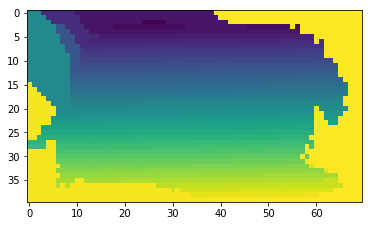

In [95]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'rgb', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Работа с серым изображением

weight matrix built!
Количество кластеров: 1811
CPU times: user 35.1 s, sys: 132 ms, total: 35.2 s
Wall time: 35.1 s


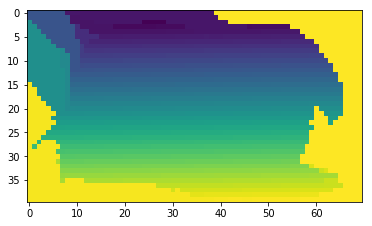

In [98]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'gray', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Отдельная кластеризация для каждого из трёх слоёв

weight matrix built!
Количество кластеров: 1868
CPU times: user 2min 4s, sys: 955 ms, total: 2min 5s
Wall time: 2min 3s


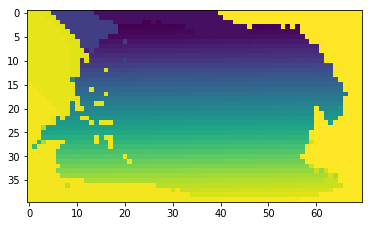

In [99]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'separate', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Учитывание только 4 близлежащих пикселей при подсчёте весов

weight matrix built!
Количество кластеров: 544
CPU times: user 18min 3s, sys: 155 ms, total: 18min 3s
Wall time: 18min 3s


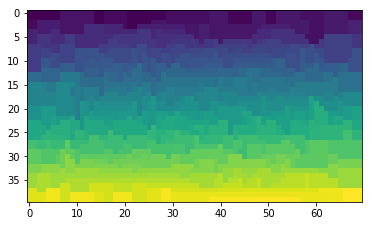

In [100]:
%%time
labels, weights = unsupervised_segmentation(apple, 'label_propagation', 'rgb', 'nearest_4', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

#### С помощью spectral clustering

Полный граф

weight matrix built!
Количество кластеров: 3
CPU times: user 38.8 s, sys: 472 ms, total: 39.3 s
Wall time: 19.8 s


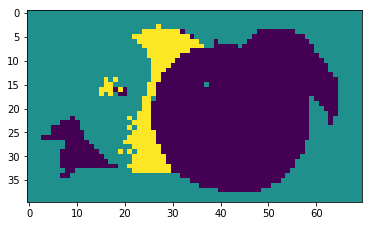

In [96]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            num_clusters=3, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

weight matrix built!
Количество кластеров: 4
CPU times: user 37.4 s, sys: 500 ms, total: 37.9 s
Wall time: 19.1 s


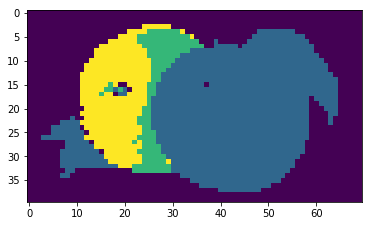

In [97]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            num_clusters=4, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Ненулевые веса только для близлежащих пикселей

weight matrix built!
Количество кластеров: 4
CPU times: user 35.3 s, sys: 525 ms, total: 35.8 s
Wall time: 20.8 s


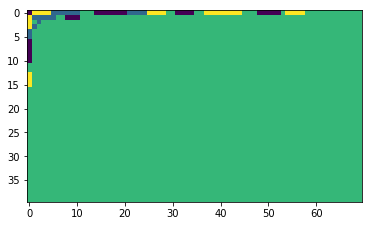

In [101]:
%%time
labels, weights = unsupervised_segmentation(apple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='radius', 
                                            weight_choice='inverse', radius=10, eps=1e-4, 
                                            num_clusters=4, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

### Теперь то же самое для картинки с ананасом

#### С помощью label propagation

In [108]:
pineapple = io.imread('./pineapple.jpg')
pineapple = rescale(pineapple, 0.1)
print(pineapple.shape)
width, height, _ = pineapple.shape

(60, 112, 3)


/home/mtg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Подсчёт расстояний по всем трём цветам

weight matrix built!
Количество кластеров: 4992
CPU times: user 1min 31s, sys: 272 ms, total: 1min 31s
Wall time: 1min 31s


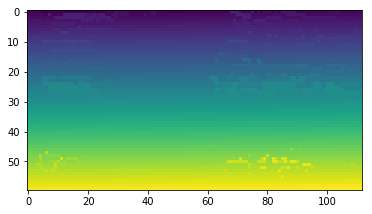

In [109]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'rgb', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Работа с серым изображением

weight matrix built!
Количество кластеров: 4603
CPU times: user 1min 34s, sys: 1.22 s, total: 1min 35s
Wall time: 1min 34s


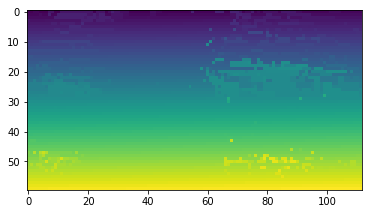

In [110]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'gray', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Отдельная кластеризация для каждого из трёх слоёв

weight matrix built!
Количество кластеров: 4935
CPU times: user 4min 55s, sys: 1.35 s, total: 4min 57s
Wall time: 4min 55s


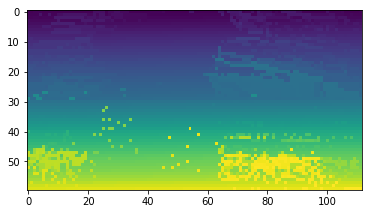

In [111]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'separate', 'radius', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

Учитывание только 4 близлежащих пикселей при подсчёте весов

weight matrix built!
Количество кластеров: 1748
CPU times: user 44min 13s, sys: 441 ms, total: 44min 13s
Wall time: 44min 13s


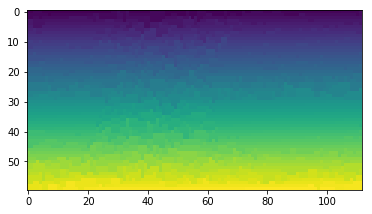

In [118]:
%%time
labels, weights = unsupervised_segmentation(pineapple, 'label_propagation', 'rgb', 'nearest_4', 'inverse', 
                                            img_dist_coef=0.0, eps=1e-4, radius=10, max_iterates=1000)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

#### С помощью spectral clustering

Полный граф

weight matrix built!
Количество кластеров: 3
CPU times: user 55 s, sys: 2.18 s, total: 57.2 s
Wall time: 30.8 s


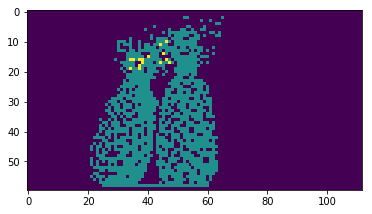

In [116]:
%%time
labels, weights = unsupervised_segmentation(pineapple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            num_clusters=3, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

weight matrix built!
Количество кластеров: 2
CPU times: user 49.1 s, sys: 2.26 s, total: 51.3 s
Wall time: 28.1 s


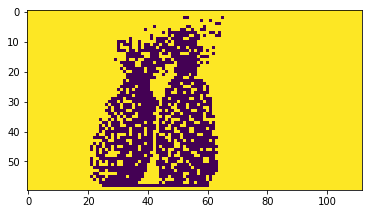

In [117]:
%%time
labels, weights = unsupervised_segmentation(pineapple, clusterisation_algorithm='spectral', 
                                            weights_strategy='rgb', 
                                            graph_type='full', 
                                            weight_choice='inverse', eps=1e-4, 
                                            num_clusters=2, num_lambda=2)
print('Количество кластеров: {}'.format(np.unique(labels).shape[0]))
plt.imshow(labels.reshape(width, height))

### Выводы:

* В целом, с помощью spectral clustering получаются более адекватные картинки

* Если рассматривать граф, в котором рёбра проводятся только между близлежащими пикселами, то получится матрица смежности, у которой значения только вблизи диагонали. Разложения для таких матриц работают плохо. Так как spectral clustering основан на svd-разложении, он не работает в этом случае.

* Если строить полный граф, то label propagation будет работать очень долго. Для полных графов лучше использовать spectral clustering.

* Чем больше плотность графа, тем больше предпочтение следует отдавать spectral clustering